In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SeparableConv2D, ReLU,GlobalMaxPool2D
from tensorflow.keras.layers import Activation,Dense, Flatten, BatchNormalization, Conv2D, Dropout,LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model 
import warnings
warnings.simplefilter(action ='ignore', category = FutureWarning)
%matplotlib inline


In [ ]:
resnet50_model = tf.keras.applications.resnet50.ResNet50(weights=None)

In [ ]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
last_layer = resnet50_model.get_layer("avg_pool")

In [ ]:
resnet_layers = keras.Model(inputs = resnet50_model.inputs, outputs = last_layer.output)

In [ ]:
resnet_layers.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
def print_layer_trainable():
    for layer in resnet_layers.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [ ]:
print_layer_trainable()

True:	input_1
True:	conv1_pad
True:	conv1_conv
True:	conv1_bn
True:	conv1_relu
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_0_bn
True:	conv2_block1_3_bn
True:	conv2_block1_add
True:	conv2_block1_out
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_3_bn
True:	conv2_block2_add
True:	conv2_block2_out
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	conv2_block3_3_conv
True:	conv2_block3_3_bn
True:	conv2_block3_add
True:	conv2_block3_out
True:	conv3_block1_1_conv
True:	conv3_block1_1_bn
True:	conv3_block1_1_relu
True:	conv3_block1

In [ ]:
for layer in resnet_layers.layers:
    layer.trainable = False

In [ ]:
for x in range(-15,0):
    resnet_layers.layers[x].trainable = True

In [ ]:
print_layer_trainable()

False:	input_1
False:	conv1_pad
False:	conv1_conv
False:	conv1_bn
False:	conv1_relu
False:	pool1_pad
False:	pool1_pool
False:	conv2_block1_1_conv
False:	conv2_block1_1_bn
False:	conv2_block1_1_relu
False:	conv2_block1_2_conv
False:	conv2_block1_2_bn
False:	conv2_block1_2_relu
False:	conv2_block1_0_conv
False:	conv2_block1_3_conv
False:	conv2_block1_0_bn
False:	conv2_block1_3_bn
False:	conv2_block1_add
False:	conv2_block1_out
False:	conv2_block2_1_conv
False:	conv2_block2_1_bn
False:	conv2_block2_1_relu
False:	conv2_block2_2_conv
False:	conv2_block2_2_bn
False:	conv2_block2_2_relu
False:	conv2_block2_3_conv
False:	conv2_block2_3_bn
False:	conv2_block2_add
False:	conv2_block2_out
False:	conv2_block3_1_conv
False:	conv2_block3_1_bn
False:	conv2_block3_1_relu
False:	conv2_block3_2_conv
False:	conv2_block3_2_bn
False:	conv2_block3_2_relu
False:	conv2_block3_3_conv
False:	conv2_block3_3_bn
False:	conv2_block3_add
False:	conv2_block3_out
False:	conv3_block1_1_conv
False:	conv3_block1_1_bn
Fal

In [ ]:
new_model = Sequential()
new_model.add(resnet_layers)
new_model.add(Dense(7,activation="softmax"))
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
train_path = '/content/drive/MyDrive/dataset/train'
valid_path = '/content/drive/MyDrive/dataset/validate'
test_path = '/content/drive/MyDrive/dataset/test'

In [ ]:
train_batch = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
     .flow_from_directory(directory = train_path, target_size=(224,224), batch_size=16)
valid_batch =ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
    .flow_from_directory(directory = valid_path, target_size=(224,224), batch_size=16)
test_batch = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
    .flow_from_directory(directory = test_path, target_size=(224,224), batch_size=16, shuffle=False )

Found 3584 images belonging to 7 classes.
Found 896 images belonging to 7 classes.
Found 1120 images belonging to 7 classes.


In [ ]:
imgs, labels = next(train_batch)
y = labels

In [ ]:
# plot images in the form of grid with 1 row and 10 colomuns 
def plotImages(images_arr):
    fig, axes = plt.subplots(1,8 , figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


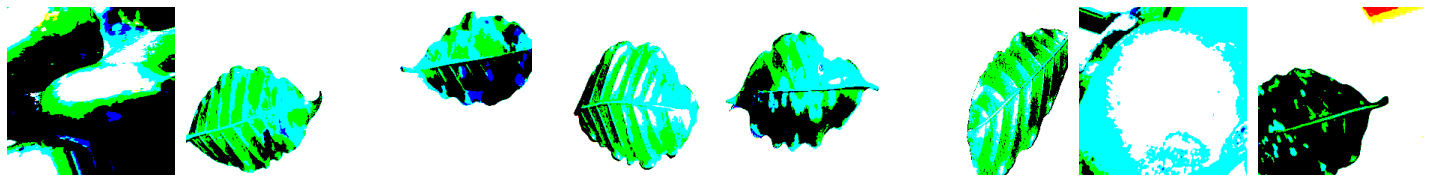

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [ ]:
plotImages(imgs)
print(labels)

In [ ]:
#sethyper parameters
Epoch = 100
FC_layers = 1024
Dropout_rate = 0.5
Batch_size = 16

In [ ]:
opt = tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.9,
    name="SGD",
)

In [ ]:
new_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=new_model.fit(x=train_batch, validation_data=valid_batch, epochs=Epoch, verbose=1)

Epoch 1/100
224/224 [==============================] - 1953s 9s/step - loss: 1.9035 - accuracy: 0.2373 - val_loss: 2.6921 - val_accuracy: 0.1752
Epoch 2/100
224/224 [==============================] - 55s 246ms/step - loss: 1.2358 - accuracy: 0.5246 - val_loss: 1.1372 - val_accuracy: 0.6027
Epoch 3/100
224/224 [==============================] - 56s 251ms/step - loss: 0.9186 - accuracy: 0.6839 - val_loss: 0.8542 - val_accuracy: 0.6696
Epoch 4/100
224/224 [==============================] - 57s 254ms/step - loss: 0.7521 - accuracy: 0.7315 - val_loss: 0.8611 - val_accuracy: 0.6618
Epoch 5/100
224/224 [==============================] - 57s 256ms/step - loss: 0.6590 - accuracy: 0.7640 - val_loss: 0.5908 - val_accuracy: 0.7779
Epoch 6/100
224/224 [==============================] - 58s 258ms/step - loss: 0.5743 - accuracy: 0.7881 - val_loss: 1.0752 - val_accuracy: 0.5681
Epoch 7/100
224/224 [==============================] - 58s 259ms/step - loss: 0.5534 - accuracy: 0.7860 - val_loss: 0.9442 - 

In [ ]:
np.mean(history.history['accuracy'])

0.929601004421711

In [ ]:
np.mean(history.history['val_accuracy'])

0.8770312492549419

In [ ]:
np.mean(history.history['loss'])

0.19725588973611594

In [ ]:
np.mean(history.history['val_loss'])

0.36456629693508147

## **Plot Result**

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


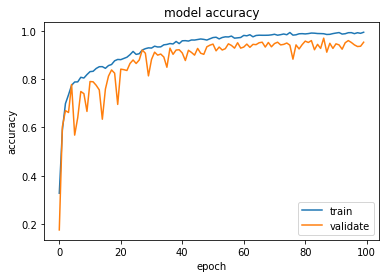

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')
plt.show()

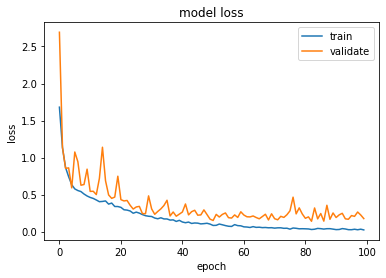

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

# Make **Prediction**

In [ ]:
prediction = new_model.predict(x=test_batch, verbose = 1)

70/70 [==============================] - 542s 8s/step


# **Plot Confusion Matrix**

In [ ]:
cm = confusion_matrix(y_true=test_batch.classes, y_pred = np.argmax(prediction,axis=-1))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Confusion matrix, without normalization
[[156   0   0   4   0   0   0]
 [  0 160   0   0   0   0   0]
 [  0   0 147   0   1   9   3]
 [  1   0   0 159   0   0   0]
 [  0   0   0   0 158   0   2]
 [  0   0   3   0   0 156   1]
 [  0   0   0   0   0   0 160]]


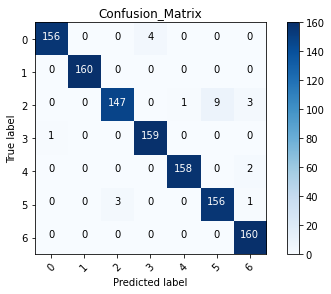

In [ ]:
cm_plot_labels =['0','1','2','3','4','5','6']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion_Matrix')

## **Evaluate The Model**

In [ ]:
from sklearn.metrics import accuracy_score
y_true = test_batch.classes
y_pred = np.argmax(prediction,axis=-1)
Acc = accuracy_score(y_true, y_pred, normalize=True)*100
print('Evaluation Accuracy = %f '% Acc)

Evaluation Accuracy = 97.857143 


In [ ]:
from sklearn.metrics import classification_report
# Print the precision and recall, among other metrics
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.994     0.975     0.984       160
           1      1.000     1.000     1.000       160
           2      0.980     0.919     0.948       160
           3      0.975     0.994     0.985       160
           4      0.994     0.988     0.991       160
           5      0.945     0.975     0.960       160
           6      0.964     1.000     0.982       160

    accuracy                          0.979      1120
   macro avg      0.979     0.979     0.978      1120
weighted avg      0.979     0.979     0.978      1120



In [ ]:
test = model.evaluate(x=test_batch, verbose = 1)

NameError: ignored

In [ ]:
mobile_model.save('mobile_model.h5')
print("Saved Model to disk")